In [1]:
import os
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '3'

import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline
sns.set_style("darkgrid")

import numpy as np
import pandas as pd
import tensorflow as tf
from tensorflow.keras import layers
from sklearn.preprocessing import RobustScaler

/opt/conda/lib/python3.10/site-packages/scipy/__init__.py:146: UserWarning: A NumPy version >=1.16.5 and <1.23.0 is required for this version of SciPy (detected version 1.23.5
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"


In [2]:
train = pd.read_csv("/kaggle/input/ventilator-pressure-prediction/train.csv", index_col=[0])
test = pd.read_csv("/kaggle/input/ventilator-pressure-prediction/test.csv", index_col=[0])

In [3]:
train.shape

(6036000, 7)

In [4]:
test.shape

(4024000, 6)

In [5]:
print(train.columns)

Index(['breath_id', 'R', 'C', 'time_step', 'u_in', 'u_out', 'pressure'], dtype='object')


In [6]:
feature_cols = ["R","C", "u_in", "u_out"]

In [7]:
RS = RobustScaler()
train[feature_cols] = RS.fit_transform(train[feature_cols])
test[feature_cols] = RS.transform(test[feature_cols])

In [8]:
n_steps = 80
n_features = len(feature_cols)

In [9]:
print(train.columns)

Index(['breath_id', 'R', 'C', 'time_step', 'u_in', 'u_out', 'pressure'], dtype='object')


In [10]:
train.shape

(6036000, 7)

In [11]:
print(train[feature_cols].values.size)

24144000


In [12]:
n_steps = 80
n_features = len(feature_cols)
target_column_name = 'pressure'  # Replace with the actual target column name

# Assuming "train" is a DataFrame containing your training data
n_samples_train = len(train) // n_steps  # Calculate the number of breaths
y_train = train[target_column_name].values[:n_samples_train * n_steps].reshape(-1, n_steps)
X_train = train[feature_cols].values[:n_samples_train * n_steps].reshape(-1, n_steps, n_features)

print(X_train.shape, y_train.shape)

(75450, 80, 4) (75450, 80)


In [13]:
def get_model(n_steps, n_features):
    model = tf.keras.Sequential([
        layers.InputLayer(input_shape=(n_steps, n_features)),
        layers.LSTM(150, return_sequences=True),
        layers.Dropout(0.2),
        layers.Flatten(),
        layers.Dense(128, activation='swish'),
        layers.Dense(256, activation='swish'),
        layers.Dense(512, activation='swish'),
        layers.Dense(80)
    ])
    return model

n_steps = 80
n_features = len(feature_cols)
model = get_model(n_steps, n_features)
model.compile(optimizer="adam", loss="mae")

model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm (LSTM)                 (None, 80, 150)           93000     
                                                                 
 dropout (Dropout)           (None, 80, 150)           0         
                                                                 
 flatten (Flatten)           (None, 12000)             0         
                                                                 
 dense (Dense)               (None, 128)               1536128   
                                                                 
 dense_1 (Dense)             (None, 256)               33024     
                                                                 
 dense_2 (Dense)             (None, 512)               131584    
                                                                 
 dense_3 (Dense)             (None, 80)                4

In [14]:
scheduler = tf.keras.optimizers.schedules.ExponentialDecay(initial_learning_rate=1e-3, decay_steps=1e4, decay_rate=1e-5)
cb_lr = tf.keras.callbacks.LearningRateScheduler(scheduler)
cb_es = tf.keras.callbacks.EarlyStopping(monitor="val_loss", patience=10, restore_best_weights=True)

history = model.fit(X_train, y_train, validation_split=0.2, epochs=200, batch_size=512, callbacks=[cb_es, cb_lr])

Epoch 1/200
118/118 [==============================] - 14s 28ms/step - loss: 2.4910 - val_loss: 1.2612 - lr: 0.0010
Epoch 2/200
118/118 [==============================] - 3s 23ms/step - loss: 1.1303 - val_loss: 1.0087 - lr: 9.9885e-04
Epoch 3/200
118/118 [==============================] - 3s 23ms/step - loss: 0.9433 - val_loss: 0.8568 - lr: 9.9770e-04
Epoch 4/200
118/118 [==============================] - 3s 22ms/step - loss: 0.8436 - val_loss: 0.7901 - lr: 9.9655e-04
Epoch 5/200
118/118 [==============================] - 3s 23ms/step - loss: 0.7807 - val_loss: 0.7391 - lr: 9.9541e-04
Epoch 6/200
118/118 [==============================] - 3s 22ms/step - loss: 0.7430 - val_loss: 0.7447 - lr: 9.9426e-04
Epoch 7/200
118/118 [==============================] - 3s 23ms/step - loss: 0.6971 - val_loss: 0.6756 - lr: 9.9312e-04
Epoch 8/200
118/118 [==============================] - 3s 23ms/step - loss: 0.6722 - val_loss: 0.6395 - lr: 9.9197e-04
Epoch 9/200
118/118 [==============================

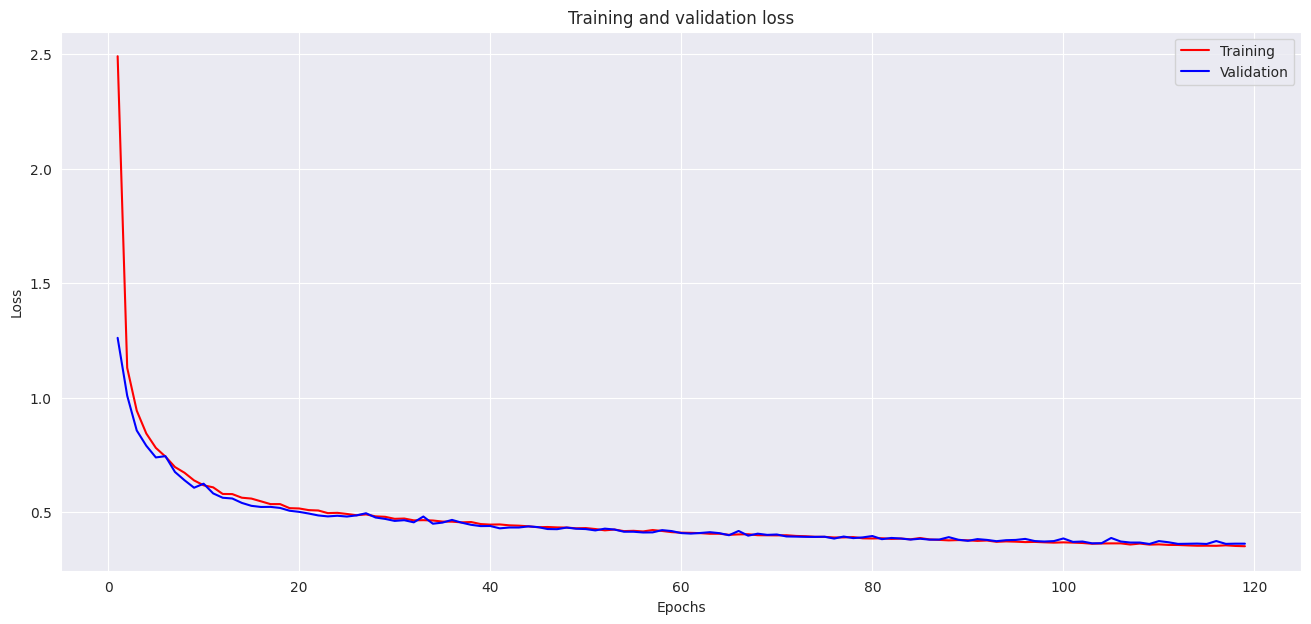

In [15]:
plt.figure(figsize=(16,7))
loss=history.history['loss']
val_loss=history.history['val_loss']

epochs=range(1,len(loss)+1)

plt.plot(epochs, loss, 'r')
plt.plot(epochs, val_loss, 'b')
plt.legend(["Training", "Validation" ])
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.title('Training and validation loss')

plt.show()

1/1 [==============================] - 0s 445ms/step


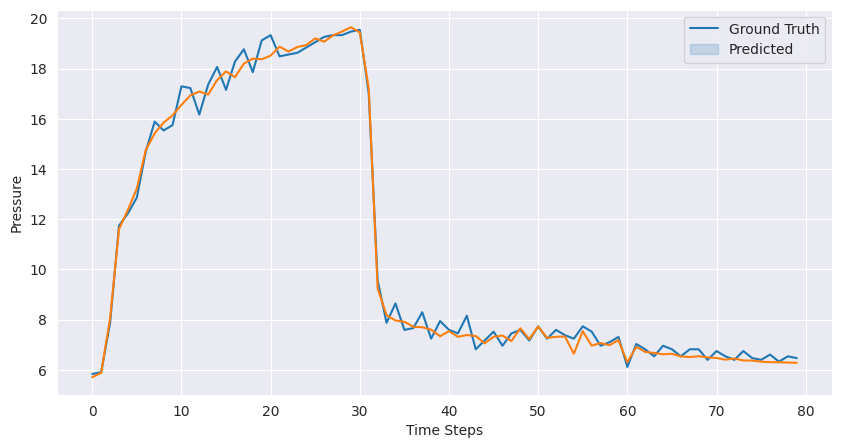

In [16]:
idx = 1
df_plot = train[train.breath_id == idx]
p = model.predict(df_plot[feature_cols].values.reshape(-1, n_steps, n_features))
x = range(80)
y = df_plot['pressure']

plt.figure(figsize=(10, 5))
sns.lineplot(y=y, x=x)
sns.lineplot(y=p.reshape(-1), x=x)
plt.legend(["Ground Truth", "Predicted"])
plt.ylabel("Pressure")
plt.xlabel("Time Steps")
plt.show()